Loan Prediction & Credit Risk Modeling

**Author:** Hugo Dahlquist  
**Project:** End-to-End Financial Forecasting Pipeline

### Executive Summary
This notebook presents a machine learning pipeline designed to predict customer loan application behavior. By analyzing historical transaction logs and demographic data, we aim to forecast monthly loan application probability. This enables proactive capital allocation and targeted cost-optimization strategies within the infrastructure.

### Technical Approach
1.  **Data Wrangling:** Robust cleaning of categorical features and handling of mixed-language raw data.
2.  **Temporal Aggregation:** Transforming transactional logs into a structured `Customer-Month` time series (expanding the grid).
3.  **Feature Engineering:** Implementing rolling window trends, lag features, and financial ratios to capture behavioral patterns.
4.  **Gradient Boosting:** Training an XGBoost classifier to predict future credit demand.

### Tech Stack
* **Python/Pandas:** Data manipulation and vectorization.
* **XGBoost:** Gradient boosting for classification.
* **Time-Series Logic:** Causal validation (Training on past, predicting future).

In [ ]:
!pip install pandas
!pip install numpy
!pip install xgboost
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

: 

In [7]:
!brew install libomp

==> Auto-updating Homebrew...
Adjust how often this is run with `$HOMEBREW_AUTO_UPDATE_SECS` or disable with
`$HOMEBREW_NO_AUTO_UPDATE=1`. Hide these hints with `$HOMEBREW_NO_ENV_HINTS=1` (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/core/portable-ruby/blobs/sha256:b48c918b7693c6d27e8027dc803a18cf64ddce49552fb45d88f3cabb9eead0fd
######################################################################### 100.0%
==> Pouring portable-ruby-3.4.7.catalina.bottle.tar.gz
==> Homebrew collects anonymous analytics.
Read the analytics documentation (and how to opt-out) here:
  https://docs.brew.sh/Analytics
No analytics have been recorded yet (nor will be during this `brew` run).

==> Homebrew is run entirely by unpaid volunteers. Please consider donating:
  https://github.com/Homebrew/brew#donations

==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
ansible@12: Automate deployment, configuration, and upgrading
auto-editor: Efficient med

In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Optimization: Configure Pandas to display all columns for easier inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Suppress warnings to keep the output clean for presentation
warnings.filterwarnings('ignore')

# Set random seed for reproducibility across runs
SEED = 123
np.random.seed(SEED)

print("Environment initialized successfully.")

Environment initialized successfully.


In [2]:
# --- Configuration ---
# Path to the raw dataset
INPUT_FILE = "TB_HUGO_MKT_MODEL_04_END_2.csv"

# Path for the final predictions output
OUTPUT_FILE = "predictions_february_optimized.csv"

In [3]:
def clean_categorical_columns(df):
    """
    Standardizes categorical variables by mapping them to numeric representations.
    
    This function handles:
    1. Mixed-language inputs (Portuguese/English labels from raw data).
    2. Missing value imputation using specific domain rules.
    3. Type conversion to ensure memory efficiency.
    """
    
    # Mapping dictionaries: Defining the schema for categorical to numeric conversion
    mappings = {
        'accountType': {'checking': 1, 'salary': 2, 'savings': 3, 'simplified': 4, 'special': 5},
        'rgdocType': {'driver': 1, 'passport': 2, 'professionalcouncil': 3, 'rg': 4, 'rne': 5},
        'civilStatus': {'married': 1, 'widowed': 2, 'divorced': 3, 'single': 4},
        'education': {'postgraduate': 1, 'college': 2, 'secondary': 3, 'primary': 4, 'illiterate': 5},
        'gender': {'f': 0, 'm': 1},
        # Housing captures mixed labels like 'Casa' (PT) and 'house' (EN)
        'housing': {'family': 1, 'mortgage': 2, 'apartment': 3, 'Casa': 3, 'house': 3, 'others': 3, 'owned': 4, 'rented': 5},
        'incomeProofDocument': {'assumed': 1, 'hol': 2, 'income-tax': 3, 'previdence': 4, 'priv-prev': 4, 'providence': 4, 'prolabore': 5, 'statement': 6, 'invoices': 7},
        'product': {'Cartao': 1, 'Consignado': 2, 'Consorcio': 3, 'CP': 4, 'FGTS': 5, 'HE': 6, 'HL': 7, 'Refin': 8, 'SeguroAuto': 9, 'SME': 10, 'wizard': 11},
        'workstatus': {'business-owner': 1, 'liberal-professional': 2, 'private-employee': 3, 'public-employee': 4, 'independent-contractor': 5, 'government-assistance': 6, 'unemployed': 7, 'retired': 8},
        'formPage': {'page_1': 1, 'page_2': 2, 'page_3': 3, 'page_4': 4, 'last_page': 4, 'form_comp': 5}
    }

    # Apply mappings. Using .map() is significantly faster than looped conditional logic.
    # Note: .fillna() handles unknown or missing categories according to business rules.
    df['accountType'] = df['accountType'].map(mappings['accountType']).fillna(6).astype(int)
    df['bankName'] = pd.to_numeric(df['bankName'], errors='coerce').fillna(0)
    df['rgdocType'] = df['rgdocType'].map(mappings['rgdocType']).fillna(7).astype(int)
    df['civilStatus'] = df['civilStatus'].map(mappings['civilStatus']).fillna(0).astype(int)
    df['education'] = df['education'].map(mappings['education']).fillna(0).astype(int)
    df['gender'] = df['gender'].map(mappings['gender']).fillna(2).astype(int)
    df['housing'] = df['housing'].map(mappings['housing']).fillna(6).astype(int)
    df['incomeProofDocument'] = df['incomeProofDocument'].map(mappings['incomeProofDocument']).fillna(0).astype(int)
    df['product'] = df['product'].map(mappings['product']).fillna(0).astype(int)
    df['workstatus'] = df['workstatus'].map(mappings['workstatus']).fillna(9).astype(int)

    # Specific handler for formPage to allow for existing numeric strings
    def clean_form_page(x):
        if pd.isna(x): return 0
        if str(x) in ['1', '2', '3', '4', '5']: return int(x)
        return mappings['formPage'].get(x, 0)
    
    df['formPage'] = df['formPage'].apply(clean_form_page)

    # Convert numeric fields and dates
    df['ownsVehicle'] = pd.to_numeric(df['ownsVehicle'], errors='coerce').fillna(2)
    df['previous_application_date'] = pd.to_datetime(df['previous_application_date'], errors='coerce').fillna(pd.Timestamp("2025-01-15"))
    df['months_since_last_application'] = pd.to_numeric(df['months_since_last_application'], errors='coerce').fillna(0)
    df['application_date'] = pd.to_datetime(df['application_date'])
    df['hasCreditRestrictions'] = pd.to_numeric(df['hasCreditRestrictions'], errors='coerce').fillna(0)

    return df

In [4]:
def create_temporal_features(df):
    """
    Transforms the dataset into a complete Time-Series format.
    
    Why: Raw data often contains only 'events' (applications). To model non-events,
    we must expand the grid to ensure every Customer-Month combination exists.
    """
    # Normalize application dates to the start of the month
    df['month'] = df['application_date'].dt.to_period('M').dt.to_timestamp()
    
    # Define the full analysis timeframe
    start_date = "2024-05-01"
    end_date = "2025-01-15"
    all_months = pd.date_range(start=start_date, end=end_date, freq='MS')
    all_customers = df['cpfRegistration'].unique()
    
    print(f"Constructing temporal grid: {len(all_customers)} customers x {len(all_months)} months...")

    # Create a MultiIndex skeleton (Cartesian product of Customers and Months)
    idx = pd.MultiIndex.from_product([all_customers, all_months], names=['cpfRegistration', 'month'])
    skeleton = pd.DataFrame(index=idx).reset_index()
    
    # Merge raw transactional data onto the temporal skeleton
    df_merged = pd.merge(skeleton, df, on=['cpfRegistration', 'month'], how='left')
    
    # Aggregation Strategy:
    # 1. Transactions (e.g., amounts) are summed.
    # 2. Static Attributes (e.g., Age, Income) take the last known value in that month.
    agg_rules = {
        'application_amount': 'sum',
        'application_count': 'sum', 
        'appliedAmount': 'sum',
        'housingTime': 'last', 'monthlyIncome': 'last', 'accountType': 'last',
        'age': 'last', 'bankName': 'last', 'rgdocType': 'last',
        'civilStatus': 'last', 'education': 'last', 'gender': 'last',
        'hasCreditRestrictions': 'last', 'housing': 'last', 'incomeProofDocument': 'last',
        'loanPeriodInMonths': 'last', 'ownsVehicle': 'last', 'product': 'last',
        'workstatus': 'last', 'formPage': 'last'
    }
    
    # Perform aggregation
    df_agg = df_merged.groupby(['cpfRegistration', 'month']).agg(agg_rules).reset_index()
    
    # Rename for clarity downstream
    df_agg = df_agg.rename(columns={'application_count': 'application_count_month'})
    df_agg['applications'] = df_agg['application_count_month'] 
    
    return df_agg

In [5]:
def create_temporal_features(df):
    """
    Expands the dataset to ensure every customer has a record for every month.
    Aggregates transactional data into monthly snapshots.
    """
    # Normalize dates to Month Start
    df['month'] = df['application_date'].dt.to_period('M').dt.to_timestamp()
    
    # Define the full timeline
    all_months = pd.date_range(start="2024-05-01", end="2025-01-15", freq='MS')
    all_customers = df['cpfRegistration'].unique()
    
    print(f"Creating timeline for {len(all_customers)} customers across {len(all_months)} months...")

    # Create MultiIndex Skeleton (Customer x Month)
    idx = pd.MultiIndex.from_product([all_customers, all_months], names=['cpfRegistration', 'month'])
    skeleton = pd.DataFrame(index=idx).reset_index()
    
    # Merge original data onto the skeleton
    df_merged = pd.merge(skeleton, df, on=['cpfRegistration', 'month'], how='left')
    
    # Aggregation Logic
    # Static features -> Last known value
    # Transactional features -> Sum
    agg_rules = {
        'application_amount': 'sum',
        'application_count': 'sum', 
        'appliedAmount': 'sum',
        'housingTime': 'last', 'monthlyIncome': 'last', 'accountType': 'last',
        'age': 'last', 'bankName': 'last', 'rgdocType': 'last',
        'civilStatus': 'last', 'education': 'last', 'gender': 'last',
        'hasCreditRestrictions': 'last', 'housing': 'last', 'incomeProofDocument': 'last',
        'loanPeriodInMonths': 'last', 'ownsVehicle': 'last', 'product': 'last',
        'workstatus': 'last', 'formPage': 'last'
    }
    
    # Group by Customer and Month
    df_agg = df_merged.groupby(['cpfRegistration', 'month']).agg(agg_rules).reset_index()
    
    # Rename for clarity
    df_agg = df_agg.rename(columns={'application_count': 'application_count_month'})
    df_agg['applications'] = df_agg['application_count_month'] 
    
    return df_agg

In [ ]:
def feature_engineering(df):
    """
    Enriches the dataset with behavioral and financial features.
    Updated to handle Timedelta calculation safely without using 'Month' units.
    """
    # 1. Target Variable Definition (Lead)
    df['application_dummy'] = (df['appliedAmount'] > 0).astype(int)
    df['target_variable'] = df.groupby('cpfRegistration')['application_dummy'].shift(-1)
    
    # 2. Imputation of Missing Static Data
    cols_to_fill = ['housingTime', 'monthlyIncome', 'accountType', 'age', 'bankName', 
                    'rgdocType', 'civilStatus', 'education', 'gender', 'hasCreditRestrictions', 
                    'housing', 'incomeProofDocument', 'ownsVehicle', 'product', 'workstatus']
    
    # Ensure columns exist before trying to fill
    existing_cols = [c for c in cols_to_fill if c in df.columns]
    df[existing_cols] = df.groupby('cpfRegistration')[existing_cols].ffill().ffill() # Check backwards fill vs forward fill
    df = df.fillna(0) 
    
    # 3. Financial Ratio Calculation
    # Force conversion to numeric to avoid object-type errors
    df['monthlyIncome'] = pd.to_numeric(df['monthlyIncome'], errors='coerce').fillna(0)
    df['appliedAmount'] = pd.to_numeric(df['appliedAmount'], errors='coerce').fillna(0)
    
    # Add epsilon to prevent DivisionByZero
    df['monthlyIncome'] = df['monthlyIncome'].replace(0, 0.01) 
    
    df['income_to_loan_ratio'] = df['appliedAmount'] / df['monthlyIncome']
    df['application_to_income_ratio'] = df['application_count_month'] / df['monthlyIncome']
    df['loan_period_to_income_ratio'] = df['loanPeriodInMonths'] / df['monthlyIncome']
    
    # 4. Recency (Time Since Last Application) -> THE FIX IS HERE
    df['last_app_date'] = df['month'].where(df['application_dummy'] == 1)
    df['last_app_date'] = df.groupby('cpfRegistration')['last_app_date'].ffill()
    
    # ERROR FIX: Calculate difference in days directly, then divide by avg days in month (30.44)
    # This avoids the "ValueError: Unit M is not supported"
    df['days_diff'] = (df['month'] - df['last_app_date']).dt.days
    df['time_since_last_application'] = df['days_diff'] / 30.44
    
    df['time_since_last_application'] = df['time_since_last_application'].fillna(0)
    df = df.drop(columns=['last_app_date', 'days_diff'])

    # 5. Rolling Behavioral Trends
    df['application_trend'] = df.groupby('cpfRegistration')['applications'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    ).fillna(0)

    # 6. Customer Loyalty
    df['five_or_more'] = (df['applications'] > 3).astype(int)
    df['returning_customer_dummy'] = df.groupby('cpfRegistration')['five_or_more'].cumprod()

    # 7. Historical Averages
    df['cum_amount'] = df.groupby('cpfRegistration')['appliedAmount'].cumsum()
    df['cum_count'] = df.groupby('cpfRegistration')['application_dummy'].cumsum()
    df['average_application_amount'] = df['cum_amount'] / df['cum_count'].replace(0, 1)
    
    return df

In [27]:
# --- DEBUGGING CELL ---

# Load the data
file_path = "/Users/admin/Desktop/Python/GitHub/TB_HUGO_MKT_MODEL_04_END_2.csv"
df_debug = pd.read_csv(file_path, na_values=["NULL"])

print("--- 1. COLUMN NAMES (Check for spaces) ---")
print(df_debug.columns.tolist())

print("\n--- 2. FIRST 5 ROWS (Where is the data?) ---")
# displaying columns of interest + a few neighbors to see if data shifted
cols_of_interest = ['cpfRegistration', 'application_date', 'appliedAmount']
# We try to print them, but if they are empty, we print the whole head to find the data
try:
    print(df_debug[cols_of_interest].head())
except KeyError:
    print("Could not find expected columns.")
    display(df_debug.head())

print("\n--- 3. DATA DUMP (First row full content) ---")
# This shows us the first row values to see if they are in the wrong place
print(df_debug.iloc[0].values)

--- 1. COLUMN NAMES (Check for spaces) ---
['id', 'created', 'cpfRegistration', 'appliedAmount', 'housingTime', 'monthlyIncome', 'accountType', 'age', 'bankName', 'rgdocType', 'civilStatus', 'education', 'gender', 'hasCreditRestrictions', 'housing', 'incomeProofDocument', 'loanPeriodInMonths', 'ownsVehicle', 'product', 'workstatus', 'formPage', 'totalLoans', 'LoanDummy', 'lastApplicationDate', 'RandomDigit', 'application_date', 'application_amount', 'application_count', 'previous_application_date', 'months_since_last_application']

--- 2. FIRST 5 ROWS (Where is the data?) ---
   cpfRegistration  application_date  appliedAmount
0              NaN               NaN            NaN
1              NaN               NaN            NaN
2              NaN               NaN            NaN
3              NaN               NaN            NaN
4              NaN               NaN            NaN

--- 3. DATA DUMP (First row full content) ---
['665a38068fba834dd1c32c00,"2024-05-31 20:50:14",63699fbd0

In [37]:
# --- Pipeline Execution (Final Fix) ---
import csv # We need this to tell pandas how to handle quotes

print("Step 1: Loading raw data with 'QUOTE_NONE'...")

# FIX: quoting=3 tells Pandas "Ignore all quote marks, just split by comma!"
raw_data = pd.read_csv(
    "/Users/admin/Desktop/Python/GitHub/TB_HUGO_MKT_MODEL_04_END_2.csv", 
    na_values=["NULL"], 
    quoting=3  # csv.QUOTE_NONE
)

print(f"   -> Loaded {len(raw_data)} rows.")

# CLEANUP: Since we ignored quotes, some might still be stuck to the text (e.g., "2024...)
# We strip them off here just in case.
for col in raw_data.columns:
    if raw_data[col].dtype == 'object':
        raw_data[col] = raw_data[col].astype(str).str.replace('"', '').str.replace("'", "")

print(f"   -> Data check (ID): {raw_data['cpfRegistration'].head(3).values}")

print("\nStep 2: Cleaning and normalizing...")
df_clean = clean_categorical_columns(raw_data)

print("Step 3: Creating temporal grid...")
df_temporal = create_temporal_features(df_clean)
print(f"   -> Temporal grid shape: {df_temporal.shape}")

print("Step 4: Engineering features...")
df_final = feature_engineering(df_temporal)

print(f"\n Pipeline Complete. Final Dataset Shape: {df_final.shape}")
df_final.head()

Step 1: Loading raw data with 'QUOTE_NONE'...
   -> Loaded 94595 rows.
   -> Data check (ID): ['63699fbd09b1c21764c26656' '63699fbd09b1c21764c26656'
 '63699fbd09b1c21764c26656']

Step 2: Cleaning and normalizing...
Step 3: Creating temporal grid...
Creating timeline for 55625 customers across 9 months...
   -> Temporal grid shape: (500625, 23)
Step 4: Engineering features...

 Pipeline Complete. Final Dataset Shape: (500625, 35)


,cpfRegistration,month,application_amount,application_count_month,appliedAmount,housingTime,monthlyIncome,accountType,age,bankName,rgdocType,civilStatus,education,gender,hasCreditRestrictions,housing,incomeProofDocument,loanPeriodInMonths,ownsVehicle,product,workstatus,formPage,applications,application_dummy,target_variable,income_to_loan_ratio,application_to_income_ratio,loan_period_to_income_ratio,time_since_last_application,application_trend,five_or_more,returning_customer_dummy,cum_amount,cum_count,average_application_amount
0,63699bd209b1c21764c263d6,2024-05-01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0.0,0,0.000000
1,63699bd209b1c21764c263d6,2024-06-01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0.0,0,0.000000
2,63699bd209b1c21764c263d6,2024-07-01,4.0,1.0,2000.0,12.0,1800.00,1.0,46.0,237.0,4.0,4.0,3.0,1.0,1.0,5.0,6.0,6.0,0.0,4.0,3.0,5.0,1.0,1,1.0,1.111111,0.000556,0.003333,0.0,0.333333,0,0,2000.0,1,2000.000000
3,63699bd209b1c21764c263d6,2024-08-01,4.0,2.0,2000.0,12.0,1800.00,1.0,46.0,237.0,4.0,4.0,3.0,1.0,1.0,5.0,2.0,6.0,0.0,4.0,3.0,5.0,2.0,1,1.0,1.111111,0.001111,0.003333,0.0,1.000000,0,0,4000.0,2,2000.000000
4,63699bd209b1c21764c263d6,2024-09-01,4.0,3.0,1000.0,12.0,1880.00,1.0,46.0,237.0,4.0,4.0,3.0,1.0,1.0,5.0,2.0,6.0,0.0,4.0,3.0,5.0,3.0,1,0.0,0.531915,0.001596,0.003191,0.0,2.000000,0,0,5000.0,3,1666.666667


In [38]:
# --- Time-Based Splitting (Combined Training) ---

# Define the timestamps
target_nov = pd.Timestamp("2024-11-01")
target_dec = pd.Timestamp("2024-12-01")
target_jan = pd.Timestamp("2025-01-01")

# 1. Training Set (November AND December)
# We use .isin() to select both months at once
train_df = df_final[df_final['month'].isin([target_nov, target_dec])]

# 2. Prediction Set (January 2025)
test_df = df_final[df_final['month'] == target_jan].copy()

# Add placeholder targets for the test set
if len(test_df) > 0:
    test_df['target_variable'] = 0 
else:
    print("WARNING: January 2025 data is missing!")

print(f"Combined Training Samples (Nov+Dec): {len(train_df)}")
print(f"Prediction Samples (Jan):            {len(test_df)}")

Combined Training Samples (Nov+Dec): 111250
Prediction Samples (Jan):            55625


Starting XGBoost training...
[0]	train-logloss:0.33939	eval-logloss:0.30691
[100]	train-logloss:0.20875	eval-logloss:0.17604
[200]	train-logloss:0.18280	eval-logloss:0.14624
[300]	train-logloss:0.17043	eval-logloss:0.13530
[400]	train-logloss:0.16146	eval-logloss:0.13027
[500]	train-logloss:0.15387	eval-logloss:0.12747
[600]	train-logloss:0.14726	eval-logloss:0.12545
[700]	train-logloss:0.14145	eval-logloss:0.12381
[800]	train-logloss:0.13635	eval-logloss:0.12257
[900]	train-logloss:0.13179	eval-logloss:0.12151
[1000]	train-logloss:0.12767	eval-logloss:0.12053
[1100]	train-logloss:0.12387	eval-logloss:0.11970
[1200]	train-logloss:0.12047	eval-logloss:0.11890
[1300]	train-logloss:0.11736	eval-logloss:0.11828
[1400]	train-logloss:0.11450	eval-logloss:0.11769
[1500]	train-logloss:0.11193	eval-logloss:0.11715
[1600]	train-logloss:0.10961	eval-logloss:0.11666
[1700]	train-logloss:0.10738	eval-logloss:0.11619
[1800]	train-logloss:0.10532	eval-logloss:0.11580
[1900]	train-logloss:0.10343	eval

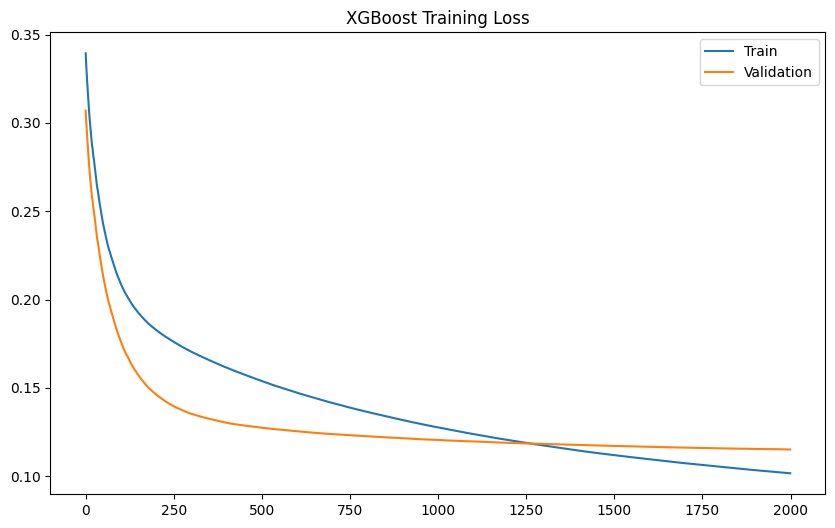

In [30]:
# Feature Selection
# Excluding non-predictive ID columns and intermediate calculation fields
drop_cols = ['cpfRegistration', 'month', 'target_variable', 'cum_amount', 'cum_count', 'five_or_more']
features = [c for c in df_final.columns if c not in drop_cols]

# Create an empty dictionary to store the training history
history = {}

# Create optimized DMatrix for XGBoost
dtrain = xgb.DMatrix(train_df[features], label=train_df['target_variable'])
dval = xgb.DMatrix(val_df[features], label=val_df['target_variable'])
dtest = xgb.DMatrix(test_df[features])

# Hyperparameter Configuration
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.01,
    'max_depth': 30,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'min_child_weight': 2,
    'gamma': 0.1,
    'lambda': 2,
    'alpha': 2,
    'nthread': 1,              # L1 Regularization
}

# Model Training
print("Starting XGBoost training...")
model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=40,
    verbose_eval=100,
    evals_result=history
)

# Plotting automatically
epochs = len(history['train']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10,6))
plt.plot(x_axis, history['train']['logloss'], label='Train')
plt.plot(x_axis, history['eval']['logloss'], label='Validation')
plt.legend()
plt.title('XGBoost Training Loss')
plt.show()

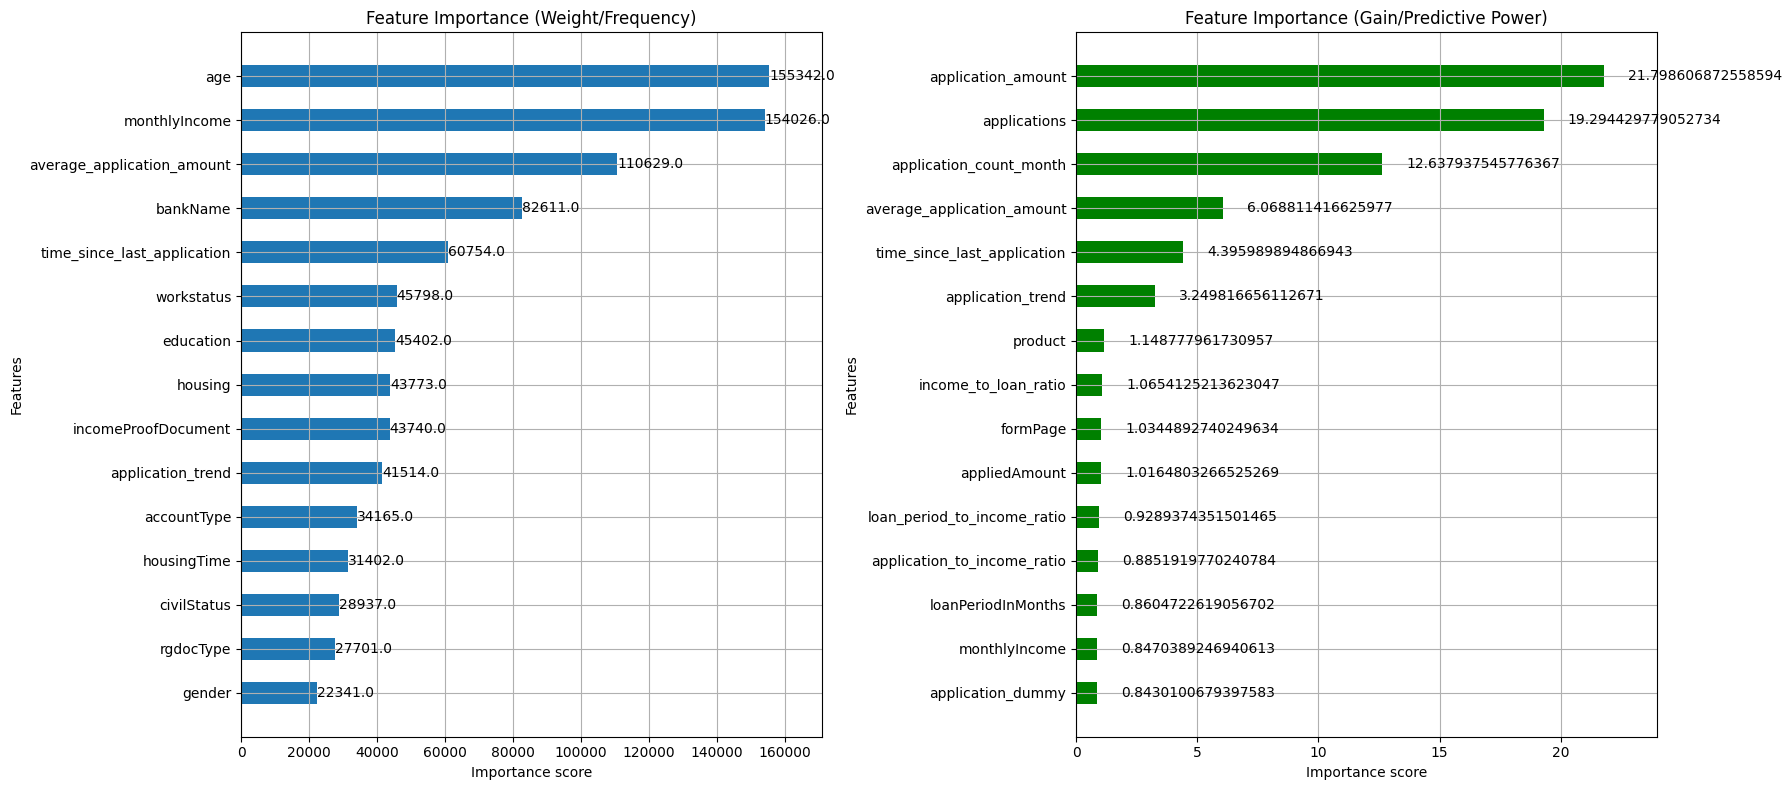

In [33]:
# Create a figure with two subplots to compare Weight vs Gain
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Weight (Frequency) - What you saw before
xgb.plot_importance(model, max_num_features=15, importance_type='weight', 
                    height=0.5, title='Feature Importance (Weight/Frequency)', ax=ax1)

# Plot 2: Gain (Quality) - The Truth Teller
xgb.plot_importance(model, max_num_features=15, importance_type='gain', 
                    height=0.5, title='Feature Importance (Gain/Predictive Power)', ax=ax2, color='green')

plt.tight_layout()
plt.show()

Model ROC-AUC Score (Training): 0.9876

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     99194
         1.0       0.76      0.78      0.77     12056

    accuracy                           0.95    111250
   macro avg       0.87      0.88      0.87    111250
weighted avg       0.95      0.95      0.95    111250



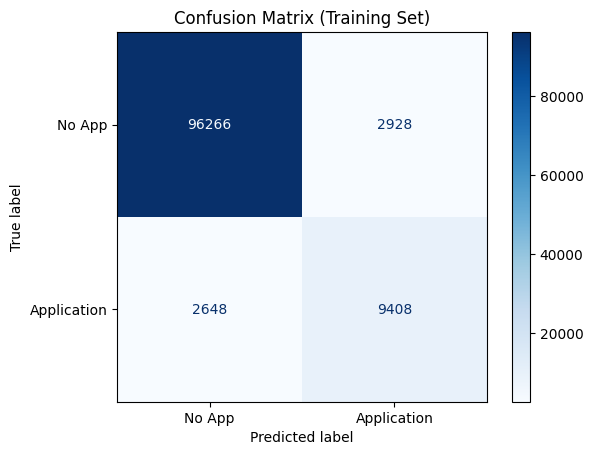

In [ ]:
# 1. Predict on the Training Data (Nov + Dec) to see how well it learned
train_preds = model.predict(dtrain)
train_labels = dtrain.get_label()

# 2. Calculate ROC-AUC (The gold standard metric)
auc = roc_auc_score(train_labels, train_preds)
print(f"Model ROC-AUC Score (Training): {auc:.4f}")

# 3. Classification Report (using 0.5 threshold)
# Convert probabilities to 0 or 1
binary_preds = (train_preds > 0.5).astype(int)

print("\n--- Classification Report ---")
print(classification_report(train_labels, binary_preds))

# 4. Confusion Matrix Visualization
cm = confusion_matrix(train_labels, binary_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No App', 'Application'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Training Set)")
plt.show()

In [ ]:
# Generate Probabilities for the Test set
test_df['Probability'] = model.predict(dtest)

# Format for submission
results = test_df[['cpfRegistration', 'Probability']]

# Save to CSV
results.to_csv(OUTPUT_FILE, index=False)
print(f"Success! Predictions saved to: {OUTPUT_FILE}")

# Preview results
results.head(10)

Success! Predictions saved to: predictions_february_optimized.csv


,cpfRegistration,Probability
8,63699bd209b1c21764c263d6,0.132165
17,63699fab09b1c21764c265c9,0.036763
26,63699fb909b1c21764c26635,0.023927
35,63699fbd09b1c21764c26656,0.020142
44,63699fcc09b1c21764c266c9,0.027498
53,63699fdc09b1c21764c26741,0.113117
62,63699ff709b1c21764c2680e,0.063451
71,6369a00609b1c21764c26884,0.023314
80,6369a01a09b1c21764c26923,0.053461
89,6369a09d09b1c21764c26d26,0.019789
